**Kaggle دانلود دیتاست از**

In [ ]:
!kaggle datasets download -d lethanhnghia/wheather-classfication

Dataset URL: https://www.kaggle.com/datasets/lethanhnghia/wheather-classfication
License(s): unknown
 83% 5.00M/6.05M [00:00<00:00, 49.0MB/s]
100% 6.05M/6.05M [00:00<00:00, 55.2MB/s]


**استخراج دیتاست**

In [ ]:
! unzip wheather-classfication.zip

Archive:  wheather-classfication.zip
  inflating: Label_wheather_class.csv  
  inflating: Weather Resized/Weather Resized/0/0.png  
  inflating: Weather Resized/Weather Resized/0/1.png  
  inflating: Weather Resized/Weather Resized/0/10.png  
  inflating: Weather Resized/Weather Resized/0/100.png  
  inflating: Weather Resized/Weather Resized/0/101.png  
  inflating: Weather Resized/Weather Resized/0/102.png  
  inflating: Weather Resized/Weather Resized/0/103.png  
  inflating: Weather Resized/Weather Resized/0/104.png  
  inflating: Weather Resized/Weather Resized/0/105.png  
  inflating: Weather Resized/Weather Resized/0/106.png  
  inflating: Weather Resized/Weather Resized/0/107.png  
  inflating: Weather Resized/Weather Resized/0/108.png  
  inflating: Weather Resized/Weather Resized/0/109.png  
  inflating: Weather Resized/Weather Resized/0/11.png  
  inflating: Weather Resized/Weather Resized/0/110.png  
  inflating: Weather Resized/Weather Resized/0/111.png  
  inflating: Weat

**اضافه کردن کتابخانه‌های مورد نیاز**

In [ ]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import matplotlib.pyplot as plt

**تقسیم دیتاست به دیتا های آموزش، تست و اعتبار سنجی**

In [ ]:
dataset_dir = Path('Weather Resized/Weather Resized')
train_dir = dataset_dir / 'train'
val_dir = dataset_dir / 'validation'
test_dir = dataset_dir / 'test'

train_dir.mkdir(parents=True, exist_ok=True)
val_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

classes = [0, 1, 2, 3]
for cls in classes:
    (train_dir / str(cls)).mkdir(parents=True, exist_ok=True)
    (val_dir / str(cls)).mkdir(parents=True, exist_ok=True)
    (test_dir / str(cls)).mkdir(parents=True, exist_ok=True)

for cls in classes:
    class_dir = dataset_dir / str(cls)
    images = list(class_dir.glob('*'))

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(img, train_dir / str(cls) / img.name)
    for img in val_imgs:
        shutil.copy(img, val_dir / str(cls) / img.name)
    for img in test_imgs:
        shutil.copy(img, test_dir / str(cls) / img.name)

print('data splited to train, validation and test')


data splited to train, validation and test


قطعه کد
ImageDataGenerator


---
برای افزایش داده‌ها و پیش‌پردازش قبل از ورود به مدل استفاده می‌شود


---


داده‌افزایی در سطح داده‌های خام انجام می‌شود و سپس داده‌ها به مدل وارد می‌شوند.

In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse'
)


Found 786 images belonging to 4 classes.
Found 169 images belonging to 4 classes.
Found 170 images belonging to 4 classes.



**بارگذاری مدل pre-trained**

---



In [ ]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

**آموزش مدل**

In [ ]:

history1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
25/25 [==============================] - 49s 2s/step - loss: 0.7914 - accuracy: 0.6692 - val_loss: 0.4314 - val_accuracy: 0.8047
Epoch 2/10
25/25 [==============================] - 48s 2s/step - loss: 0.4527 - accuracy: 0.8270 - val_loss: 0.2900 - val_accuracy: 0.9053
Epoch 3/10
25/25 [==============================] - 48s 2s/step - loss: 0.3773 - accuracy: 0.8626 - val_loss: 0.2759 - val_accuracy: 0.8935
Epoch 4/10
25/25 [==============================] - 47s 2s/step - loss: 0.3279 - accuracy: 0.8715 - val_loss: 0.2553 - val_accuracy: 0.9112
Epoch 5/10
25/25 [==============================] - 46s 2s/step - loss: 0.2982 - accuracy: 0.8753 - val_loss: 0.2048 - val_accuracy: 0.9290
Epoch 6/10
25/25 [==============================] - 48s 2s/step - loss: 0.2698 - accuracy: 0.9020 - val_loss: 0.1921 - val_accuracy: 0.9349
Epoch 7/10
25/25 [==============================] - 49s 2s/step - loss: 0.2411 - accuracy: 0.9071 - val_loss: 0.1925 - val_accuracy: 0.9349
Epoch 8/10
25/25 [==

نمودار ارزیابی دقت train و test

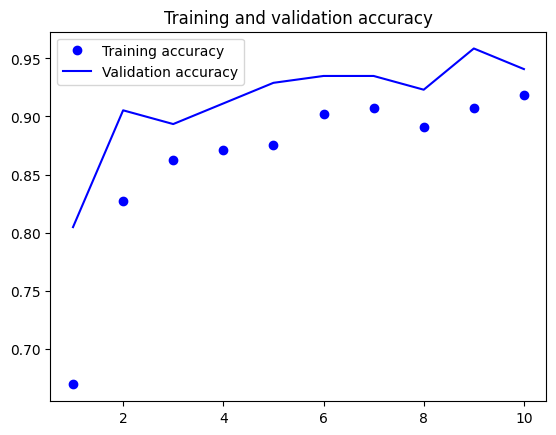

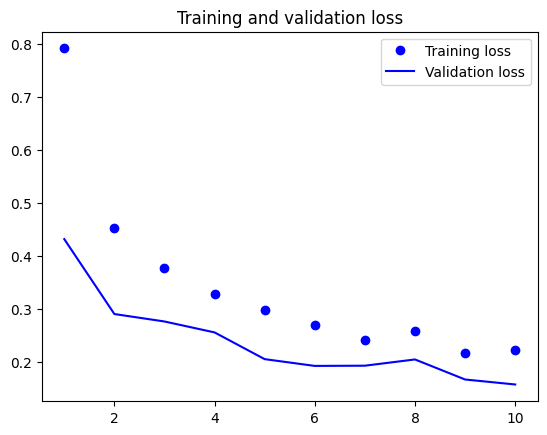

In [ ]:
acc1 = history1.history["accuracy"]
val_acc1 = history1.history1["val_accuracy"]
loss1 = history1.history1["loss"]
val_loss1 = history1.history1["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**ارزیابی مدل**

In [ ]:

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


6/6 [==============================] - 9s 1s/step - loss: 0.1596 - accuracy: 0.9471
Test accuracy: 0.9470587968826294


این کد از تابع image_dataset_from_directory کتابخانه TensorFlow.keras.utils استفاده می‌کند تا دیتاست‌های تصویری را از ساختار پوشه دیتاست خوانده و به صورت دیتاست TensorFlow ایجاد کند. این تابع به صورت خودکار داده‌ها را بارگذاری می‌کند، آن‌ها را پیش‌پردازش می‌کند و به صورت دسته‌هایی به مدل شما می‌دهد که برای آموزش و ارزیابی مدل استفاده می‌شوند.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "Weather Resized/Weather Resized/train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "Weather Resized/Weather Resized/validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "Weather Resized/Weather Resized/test",
    image_size=(180, 180),
    batch_size=32)

Found 786 files belonging to 4 classes.
Found 169 files belonging to 4 classes.
Found 170 files belonging to 4 classes.


تعریف data augmentation


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

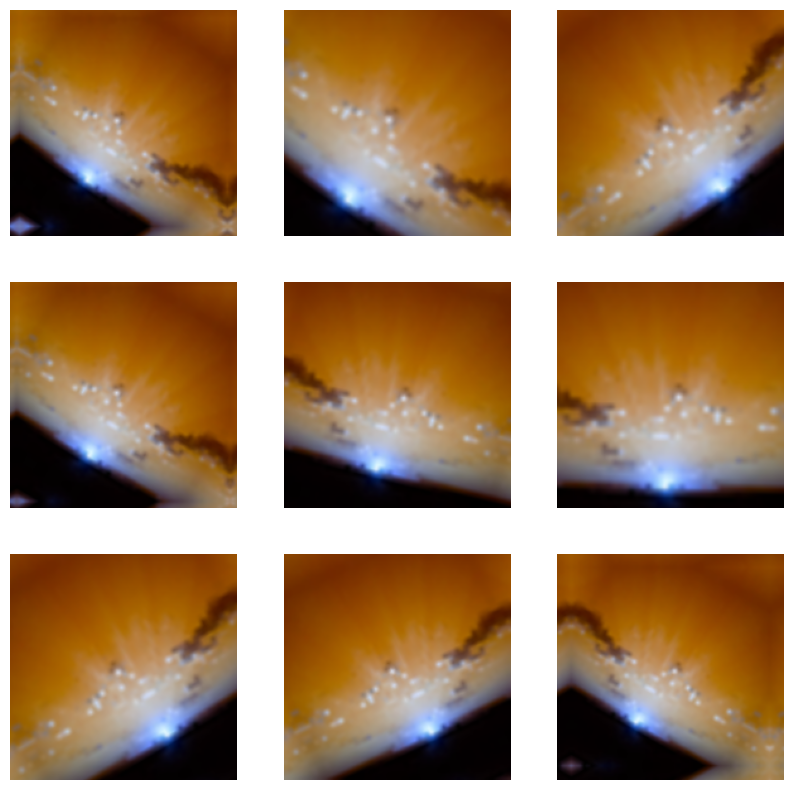

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


for layer in base_model.layers:
    layer.trainable = False


inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]


model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028

In [ ]:
history2 = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/15
25/25 [==============================] - 49s 2s/step - loss: 0.8591 - accuracy: 0.6590 - val_loss: 0.4165 - val_accuracy: 0.8462
Epoch 2/15
25/25 [==============================] - 50s 2s/step - loss: 0.4938 - accuracy: 0.8142 - val_loss: 0.2690 - val_accuracy: 0.8994
Epoch 3/15
25/25 [==============================] - 47s 2s/step - loss: 0.4225 - accuracy: 0.8499 - val_loss: 0.2686 - val_accuracy: 0.9112
Epoch 4/15
25/25 [==============================] - 50s 2s/step - loss: 0.3783 - accuracy: 0.8537 - val_loss: 0.2410 - val_accuracy: 0.9172
Epoch 5/15
25/25 [==============================] - 46s 2s/step - loss: 0.3313 - accuracy: 0.8702 - val_loss: 0.2038 - val_accuracy: 0.9172
Epoch 6/15
25/25 [==============================] - 46s 2s/step - loss: 0.3254 - accuracy: 0.8715 - val_loss: 0.2865 - val_accuracy: 0.8580
Epoch 7/15
25/25 [==============================] - 50s 2s/step - loss: 0.3045 - accuracy: 0.8830 - val_loss: 0.2256 - val_accuracy: 0.9112
Epoch 8/15
25/25 [==

In [ ]:

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

6/6 [==============================] - 9s 1s/step - loss: 0.1540 - accuracy: 0.9588
Test accuracy: 0.9588235020637512


**انجام عمل fine-tune**

In [ ]:

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'])


total_epochs = 20

**آموزش مدل پس از fine-tune**

In [ ]:
history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    initial_epoch=history.epoch[-1]
)

Epoch 15/20
25/25 [==============================] - 63s 2s/step - loss: 0.2170 - accuracy: 0.9122 - val_loss: 0.1821 - val_accuracy: 0.9408
Epoch 16/20
25/25 [==============================] - 66s 3s/step - loss: 0.2158 - accuracy: 0.9198 - val_loss: 0.1660 - val_accuracy: 0.9290
Epoch 17/20
25/25 [==============================] - 61s 2s/step - loss: 0.1975 - accuracy: 0.9173 - val_loss: 0.1789 - val_accuracy: 0.9290
Epoch 18/20
25/25 [==============================] - 65s 3s/step - loss: 0.1737 - accuracy: 0.9338 - val_loss: 0.1939 - val_accuracy: 0.9172
Epoch 19/20
25/25 [==============================] - 60s 2s/step - loss: 0.1757 - accuracy: 0.9313 - val_loss: 0.1935 - val_accuracy: 0.9172
Epoch 20/20
25/25 [==============================] - 63s 3s/step - loss: 0.1709 - accuracy: 0.9466 - val_loss: 0.1612 - val_accuracy: 0.9408


**ارزیابی نهایی مدل پس از fine-tune**

In [ ]:

test_loss, test_acc = model.evaluate(test_generator)
print(f'Fine-tuned test accuracy: {test_acc}')


6/6 [==============================] - 9s 1s/step - loss: 0.1165 - accuracy: 0.9706
Fine-tuned test accuracy: 0.970588207244873
